# Queue Imbalance as a One-Tick-Ahead Price Predictor in LOB


Order of this notebook is as follows:
1. [Data](#Data)
2. [Methodology](#Methodology)
3. [Results](#Results)
4. [Conclusions](#Conclusions)

Goal is to implement queue imbalance predictor from [[1]](#Resources).

In [1]:
%matplotlib inline
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as md
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import warnings

import lob

sns.set_style('whitegrid')

warnings.filterwarnings('ignore')

# Data

We use data from 5 stocks from 2013-09 - 2013-11. The market is open between 8-16 on weekdays, so we use the data from 9-15 to avoid having data affected by the abnormal trading behaviour, which usually occurs right after opening or closing auction. The tick size is $\pi = 0.01$ for the market, but the *relative tick size*(the ratio between stock price and $\pi$) for each stock differs.

To each stock data we introduce:

* bid price: $$ b(t) := \underset{\{x \in bidList(t) \}}{\max} x.price $$
* ask price: $$ a(t) := \underset{\{x \in askList(t)\}}{\min} x.price $$

* total size of active buy orders: $$ n^{b}(p, t) = \sum_{\{x \in buyList(t), p_x = p\}} x.volumen $$

* total size of active sell orders: $$ n^{a}(p, t) = \sum_{\{x \in askList(t), p_x = p\}} x.volumen $$


* mid price: $$ m(t) := \frac{a(t) + b(t)}{2} $$

* queue imbalance: $$ I(t) := \frac{n^b (b_t , t) - n^a (a_t, t)}{n^b (b_t , t) + n^a (a_t, t)} $$ where $a_t$ and $b_t$ are ask and bid prices for time $t$ respectively.

* mid price indicator: $$ y_i = \begin{cases} 1 & \text{if} & m(t_i) > m(t_{i-1})\\ 0 & \text{if} & m(t_i) < m(t_{i-1})\\ \end{cases} $$

Based on the **queue imbalance** we will try to predict **mid price indicator**

In [2]:
dfs = {}
dfs_test = {}
stocks = ['9061', '9062', '9063', '9064', '9065']

for s in stocks:
    d, d_test = lob.load_data(s)
    dfs[s] = d
    dfs_test[s] = d_test

Training set length for 9061: 14015
Testing set length for 9061: 4653
Training set length for 9062: 14317
Testing set length for 9062: 4685
Training set length for 9063: 13456
Testing set length for 9063: 4507
Training set length for 9064: 14322
Testing set length for 9064: 4855
Training set length for 9065: 10320
Testing set length for 9065: 3810


### Description of DataFrame

The data is indexed with time $t$.

* `bid` - bid queue
* `ask` - ask queue
* `bid_price` - bid price $b(t)$
* `ask_price` - ask price $a(t)$
* `mid_price` - mid price $m(t)$
* `sum_sell_ask` - total size of active sell orders for ask price  $ n^{a}(a(t), t) $
* `sum_buy_bid` - total size of active buy orders for bid price  $ n^{b}(b(t), t) $
* `mid_price_indicator` - the indicator if the mid price will rise in the **next** time tick
* `queue_imbalance` - $I(t)$

In [3]:
dfs['9061'].head(10)

,bid,ask,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance
2013-09-16 09:00:00,"[(550.0, 6364.0), (615.0, 273.0), (630.0, 1510...","[(704.7, 8086.0), (704.8, 4071.0), (704.9, 113...",704.4,704.7,704.55,8086.0,4648.0,1.0,-0.269986
2013-09-16 09:01:00,"[(550.0, 6364.0), (615.0, 273.0), (630.0, 1510...","[(705.2, 274.0), (705.3, 10033.0), (705.4, 122...",705.0,705.2,705.10,274.0,2700.0,1.0,0.815736
2013-09-16 09:02:00,"[(550.0, 6364.0), (615.0, 273.0), (630.0, 1510...","[(705.5, 1200.0), (705.6, 1568.0), (705.7, 459...",705.4,705.5,705.45,1200.0,3050.0,0.0,0.435294
2013-09-16 09:03:00,"[(550.0, 6364.0), (615.0, 273.0), (630.0, 1510...","[(705.4, 9121.0), (705.5, 18238.0), (705.6, 10...",705.1,705.4,705.25,9121.0,8942.0,0.0,-0.009910
2013-09-16 09:04:00,"[(550.0, 6364.0), (615.0, 273.0), (630.0, 1510...","[(705.3, 1670.0), (705.4, 10269.0), (705.5, 25...",705.0,705.3,705.15,1670.0,5625.0,1.0,0.542152
2013-09-16 09:05:00,"[(550.0, 6364.0), (615.0, 273.0), (630.0, 1510...","[(705.7, 5006.0), (705.8, 12619.0), (705.9, 10...",705.4,705.7,705.55,5006.0,6416.0,1.0,0.123446
2013-09-16 09:06:00,"[(550.0, 6364.0), (615.0, 273.0), (630.0, 1510...","[(706.0, 10606.0), (706.1, 9858.0), (706.2, 11...",705.6,706.0,705.80,10606.0,7067.0,0.0,-0.200249
2013-09-16 09:07:00,"[(550.0, 6364.0), (615.0, 273.0), (630.0, 1510...","[(705.5, 4131.0), (705.6, 11298.0), (705.7, 12...",705.3,705.5,705.40,4131.0,714.0,1.0,-0.705263
2013-09-16 09:08:00,"[(550.0, 6364.0), (615.0, 273.0), (630.0, 1510...","[(705.7, 3931.0), (705.8, 11257.0), (705.9, 11...",705.4,705.7,705.55,3931.0,2524.0,0.0,-0.217971
2013-09-16 09:09:00,"[(550.0, 6364.0), (615.0, 273.0), (630.0, 1510...","[(705.6, 6031.0), (705.7, 8793.0), (705.8, 157...",705.3,705.6,705.45,6031.0,4503.0,1.0,-0.145054


### Stock characteristic

For each stock we want to know how the can compare the *relative tick size* as the authors of [[1]](#Resources) saw it's is relevant for predictions. They decided that stocks are: 

* *large-tick stocks* when **maximal trade price** was below $50.00$
* *small-tick stocks* when **minimal trade price** was above $100.00$

They found out that the stocks which were between these two tresholds could behave similarily to both of these groups. 
    
The means of $n^{b}(b(t), t)$ and $n^{a}(a(t), t)$ for:

* *large-tick* stocks were above 3000 
* *small-tick* stocks were below 200

The bid ask spread for:

* *large-tick* stocks was below 0.02
* *small-tick* stocks was above 0.2

### Tick sizes for our data

* 9061 - looks like intermediate tick, but behaves like small
* 9062 - small tick
* 9063 - small tick
* 9064 - intermediate tick
* 9065 - small tick

In [4]:
df_summary = pd.DataFrame(index=stocks)
sum_sell_ask_mean = []
sum_buy_bid_mean = []
max_trade_price = []
min_trade_price = []
bid_ask_spread = []

for s in stocks:
    sum_sell_ask_mean.append(dfs[s]['sum_sell_ask'].mean())
    sum_buy_bid_mean.append(dfs[s]['sum_buy_bid'].mean())
    max_trade_price.append(max( dfs[s]['bid_price'].max(), dfs[s]['ask_price'].max()))
    min_trade_price.append(max( dfs[s]['bid_price'].min(), dfs[s]['ask_price'].min()))
    bid_ask_spread.append((dfs[s]['ask_price'] - dfs[s]['bid_price']).mean())

df_summary['sum_sell_ask_mean'] = sum_sell_ask_mean
df_summary['sum_buy_bid_mean'] = sum_buy_bid_mean
df_summary['max_trade_price'] = max_trade_price
df_summary['min_trade_price'] = min_trade_price
df_summary['bid_ask_spread'] = bid_ask_spread
df_summary.head()

,sum_sell_ask_mean,sum_buy_bid_mean,max_trade_price,min_trade_price,bid_ask_spread
9061,6553.136068,6998.576953,730.20,662.30,0.170439
9062,937.262765,955.716002,3405.00,2937.00,1.022386
9063,8118.569634,7583.728523,510.10,427.05,0.093430
9064,28784.069823,27734.329982,80.88,72.70,0.024918
9065,6464.204070,6594.876163,1695.50,1536.00,0.662984


# Methodology 

We perform classification using logistic regression and svm.

### Sample construction

As the authors of the [[1]](#Resources) didn't see difference in sampling in-between data samples we stick to the original timestamps of the events. We also tried to pick 100 samples per day, but it didn't lead to better results.

### Data in-sample and out-of-sample

Test set is 20% of data we have, the rest 80% is training set - we pick data from first two weeks of 2013-09 as test data. 

The authors used 25200 data points per stock, we have about 12000 per stock. Authors randomly picked the time range with 20% of data for training set. They picked randomly about 100 points for each day instead of using all the data they had.

We tried to do similar sampling, but with 200 and 300 points per day, it didn't bring any different results. But we have data for only 2 months, instead of 12 months, so this approach cuts the amount of data drastically.

### Formulating predictions with logistic regression

We perform a logistic regression of mid price indicator $y$ based on queue imbalance $I$. Specifically, we use the data in our training set to calculate
maximum likelihood estimates of the coefficients $x_0$ and $x_1$:

$$ \hat{y}(I) = \frac{1}{1 + e^{-(x_0 + Ix_1 )}}$$

If $\hat{y}(I) > \frac{1}{2}$ we predict that the mid price will raise in the next tick.

In [5]:
reg = {}
reg_svm = {}

for s in stocks:
    reg[s] = lob.logistic_regression(dfs[s], 0, len(dfs[s]))
    reg_svm[s] = lob.svm_classification(dfs[s], 0, len(dfs[s]))

In [6]:
pred_in_sample = {}
pred_out_of_sample = {}
for s in stocks:
    pred_in_sample[s] = reg[s].predict(dfs[s]['queue_imbalance'].values.reshape(-1, 1))
    pred_out_of_sample[s] = reg[s].predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))
    
pred_svm_in_sample = {}
pred_svm_out_of_sample = {}
for s in stocks:
    pred_svm_in_sample[s] = reg_svm[s].predict(dfs[s]['queue_imbalance'].values.reshape(-1, 1))
    pred_svm_out_of_sample[s] = reg_svm[s].predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))

# Results

## Distribution of $I$

### Denisty plot

From the queue imbalance density plot we can see that we can observe wide range of imbalances between $-\frac{1}{2}$ and $\frac{1}{2}$ for **9061**, **9062**, **9064** and it decays outside this range. It looks more like *large-tick stock* imbalance distribution from the [[1]](#Resources). 

The **9062** is not smooth.
The **9063** is more assymetric. 
The **9065** is more steep than the rest.

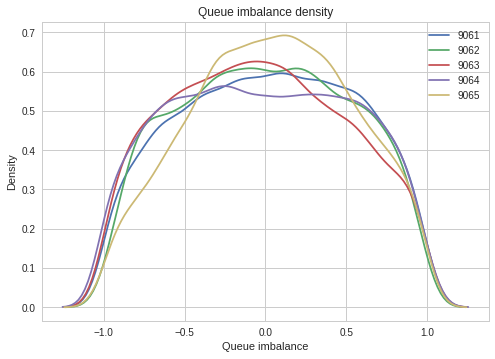

In [7]:
for s in stocks:
    sns.kdeplot(np.array(dfs[s]['queue_imbalance']), label=s)

plt.legend()
plt.xlabel('Queue imbalance')
plt.ylabel('Density')
plt.title('Queue imbalance density')

### ECDF curve

The ECDF (emprical cumulative density functions) curve of the bid and ask prices queue lengths is smooth, which indicates that the queues lengths differ. 

For the **9062** it explains why it is not so pleated - it has an steep artifact near $(100, 0.95)$.

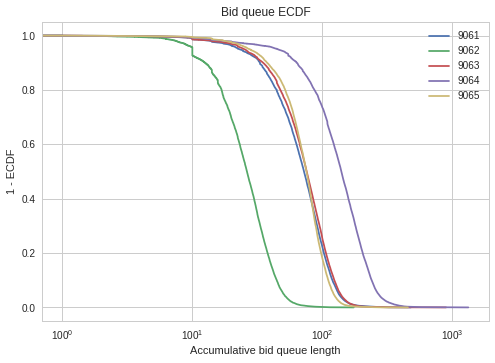

In [8]:
ax = plt.subplot()
ax.set_xscale("log", basex=100)
for s in stocks:
    ecdf = ECDF(np.array( dfs[s]['sum_buy_bid']))
    e = 1 - ecdf.y
    plt.plot(ecdf.x, e, label=s)
plt.legend()
plt.ylabel('1 - ECDF')
plt.xlabel('Accumulative bid queue length')
plt.title('Bid queue ECDF')

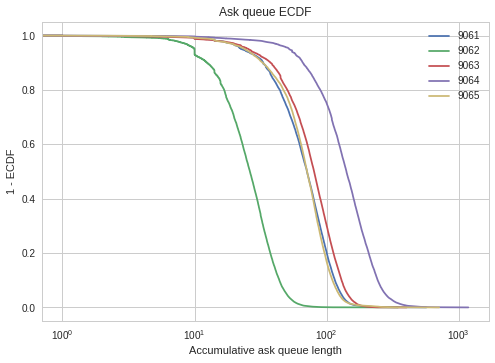

In [9]:
ax = plt.subplot()
ax.set_xscale("log", basex=100)
for s in stocks:
    ecdf = ECDF(np.array( dfs[s]['sum_sell_ask']))
    e = 1 - ecdf.y
    plt.plot(ecdf.x, e, label=s)
plt.legend()
plt.legend()
plt.ylabel('1 - ECDF')
plt.xlabel('Accumulative ask queue length')
plt.title('Ask queue ECDF')

## Logistic Regression fits


### Likelihood estimates
$$ \hat{y}(I) = \frac{1}{1 + e^{-(x_0 + Ix_1 )}}$$

We can see that $x_0$ value is small - this suggests that there is a symmetric behaviour in terms of buying and selling activity.

The $x_1$ is positive in each case.
This implies that the logistic regression line is an increasing function. So that 
suggests that the larger the queue imbalance, the higher the probability that the next mid-price will go up.

In [[1]](#Resources) the authors noticed that the fitted values of $x_1$ are much larger for large-tick stocks (for which
they vary from about 2 to about 3) than for small-tick stocks (for which they
vary from about 0.5 to about 0.8).

In [10]:
df_reg = pd.DataFrame(index=stocks)
x1 = []
x0 = []
for s in stocks:
    x1.append(reg[s].coef_[0][0])
    x0.append(reg[s].intercept_[0])
df_reg['x1'] = x1
df_reg['x0'] = x0
df_reg.head()

,x1,x0
9061,0.180141,-0.012844
9062,0.235512,0.012316
9063,0.221616,0.007513
9064,0.381952,0.031048
9065,0.592615,-0.005635


### Fitted logistic regression curves

The fitted curves are monotonically increasing. 
They look almost like a straingth lines, which is more charactersitc to the *small-tick* stocks according to [[1]](#Resources).

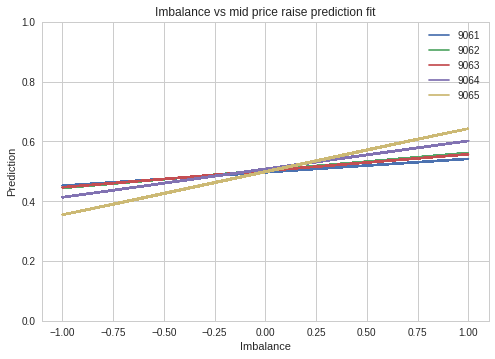

In [11]:
for s in stocks:
    plt.plot(dfs[s]['queue_imbalance'].values, 
             lob.sigmoid(reg[s].coef_[0] * dfs[s]['queue_imbalance'].values + reg[s].intercept_), '-', label=s)
plt.title('Imbalance vs mid price raise prediction fit')
plt.xlabel('Imbalance')
plt.ylabel('Prediction')
plt.ylim(0, 1)
plt.legend()

## Assessing predictions for logistic regression

### Mean square error 

We calculate residual $r_i$:

$$ r_i = \hat{y_i} - y_i $$

We use mean square residual on testing set to assess the predictive power.

In [12]:
for s in stocks:
    err = ((dfs_test[s]['mid_price_indicator'].values - reg[s].predict_proba(
        dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))[:,1]) ** 2).mean()
    print('Error for {} is {}'.format(s, err))

Error for 9061 is 0.24862156637890787
Error for 9062 is 0.24788127988291345
Error for 9063 is 0.24736939463294305
Error for 9064 is 0.24798535046682377
Error for 9065 is 0.2460104897226865


### ROC curves

We calculate the out-of-sample ROC curves and area-under-ROC-curve statistics to
assess the predectivity power of both svm and logistic regressions.

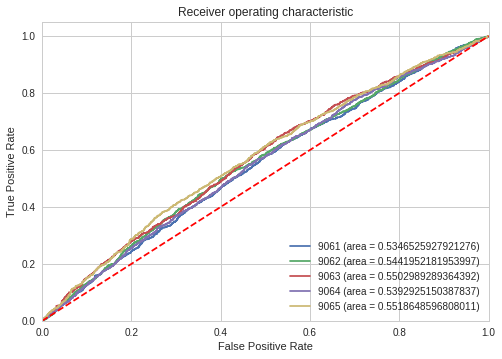

In [13]:
for s in stocks:
    logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], pred_out_of_sample[s])
    fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, 
                                     reg[s].predict_proba(dfs_test[s]['queue_imbalance'].reshape(-1, 1))[:,1])
    plt.plot(fpr, tpr, label='{} (area = {})'.format(s, logit_roc_auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [14]:
from sklearn.metrics import classification_report
for s in stocks:
    print(s)
    print(classification_report(pred_in_sample[s], dfs[s]['mid_price_indicator'].values))
    print()

9061
             precision    recall  f1-score   support

        0.0       0.58      0.55      0.56      7388
        1.0       0.52      0.55      0.54      6627

avg / total       0.55      0.55      0.55     14015


9062
             precision    recall  f1-score   support

        0.0       0.50      0.53      0.51      6664
        1.0       0.57      0.53      0.55      7653

avg / total       0.53      0.53      0.53     14317


9063
             precision    recall  f1-score   support

        0.0       0.57      0.56      0.56      6867
        1.0       0.55      0.56      0.55      6589

avg / total       0.56      0.56      0.56     13456


9064
             precision    recall  f1-score   support

        0.0       0.51      0.54      0.53      6684
        1.0       0.58      0.55      0.56      7638

avg / total       0.55      0.54      0.54     14322


9065
             precision    recall  f1-score   support

        0.0       0.53      0.56      0.54      4901
    

##  SVM

In [15]:
for s in stocks:
    err = ((dfs_test[s]['mid_price_indicator'].values - reg_svm[s].predict_proba(
        dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))[:,1]) ** 2).mean()
    print('Error for {} is {}'.format(s, err))

Error for 9061 is 0.24875282036210727
Error for 9062 is 0.24788985244723513
Error for 9063 is 0.2469677762225725
Error for 9064 is 0.24797810925291308
Error for 9065 is 0.24605211153769296


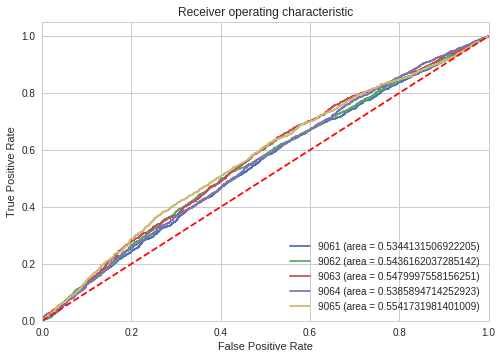

In [16]:
for s in stocks:
    logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], pred_svm_out_of_sample[s])
    fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, 
                                     reg_svm[s].predict_proba(dfs_test[s]['queue_imbalance'].reshape(-1, 1))[:,1])
    plt.plot(fpr, tpr, label='{} (area = {})'.format(s, logit_roc_auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [17]:
for s in stocks:
    print(s)
    print(classification_report(pred_svm_in_sample[s], dfs[s]['mid_price_indicator']))

9061
             precision    recall  f1-score   support

        0.0       0.59      0.55      0.57      7568
        1.0       0.51      0.55      0.53      6447

avg / total       0.55      0.55      0.55     14015

9062
             precision    recall  f1-score   support

        0.0       0.50      0.53      0.51      6720
        1.0       0.56      0.53      0.55      7597

avg / total       0.53      0.53      0.53     14317

9063
             precision    recall  f1-score   support

        0.0       0.60      0.56      0.58      7250
        1.0       0.52      0.56      0.54      6206

avg / total       0.56      0.56      0.56     13456

9064
             precision    recall  f1-score   support

        0.0       0.53      0.54      0.53      6987
        1.0       0.55      0.55      0.55      7335

avg / total       0.54      0.54      0.54     14322

9065
             precision    recall  f1-score   support

        0.0       0.55      0.55      0.55      5091
        

# Conclusions

* there is almost no difference between using SVM and logistic regression for this data sets
* the data sets don't have characteristic tick size as the data used by authors of article [[1]](#Resources)
* our results are a bit worse than their results for *small-tick* stocks, but we had much less data, which wasn't preprocessed so carefully (they used the data from the whole year, we use from 2 months). We cleaned the data from morning and evening events, but other outliers weren't removed.

### Resources

1. [Queue Imbalance as a One-Tick-Ahead Price Predictor in a Limit Order Book](https://arxiv.org/abs/1512.03492) <a class="anchor-link" href="#1">¶</a>

In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss

cross_val_score(reg[s], dfs[s]['queue_imbalance'].values.reshape(-1, 1), 
                dfs[s]['mid_price_indicator'].values, scoring='neg_log_loss')

prob = reg[s].predict_proba(dfs[s]['queue_imbalance'].reshape(-1, 1))
log_loss(dfs[s]['mid_price_indicator'].values.reshape(-1, 1), prob[:, 1], eps=1e-15)

0.6827732960226387